In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import os

from model.datasets import get_CIFAR10
from model.ddpm import DiffusionTrainer, DiffusionSampler
from model.unet import Unet
from model.training import train, sample
from model.utils import SaveBestModel, load_model, plot_images
from model.metrics import fid_score

import gc
from tqdm.notebook import tqdm

ModuleNotFoundError: No module named 'torchmetrics'

In [6]:
torch.cuda.empty_cache()
gc.collect()

1031

In [3]:
CUDA = 0
batch_size = 64

dataloader = get_CIFAR10(batch_size=batch_size)
device = torch.device(f"cuda:{CUDA}" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified


In [4]:
device

device(type='cuda', index=0)

In [5]:
unet = Unet(T=1000, n_channels=128, channels_mul=[1, 2, 2, 2], n_residual_blocks=2, dropout=0.1).to(device)
model = DDPM(unet, device=device)


In [6]:
model.load_state_dict(torch.load('bin/ddpm.pth')['model_state_dict'])

<All keys matched successfully>

In [68]:
def denormalize(data):
    data = data * 0.5 + 0.5
    #data = (data * 255).type(torch.uint8)
    return data

In [72]:
fake_data = sample(model, batch_size, (3, 32, 32), batch_size, device)
torch.save(fake_data, 'fake_data.pt')

Going to sample 1 batches
Sampling 1 batch...


100%|██████████| 1000/1000 [04:03<00:00,  4.11it/s]


In [79]:
real_data = next(iter(dataloader))[0]
real_data = denormalize(real_data).detach().cpu()

fake_data = torch.load('fake_data.pt')
fake_data = denormalize(fake_data).detach().cpu()

print(real_data.shape, real_data.dtype)
print(fake_data.shape, fake_data.dtype)

torch.Size([64, 3, 32, 32]) torch.float32
torch.Size([64, 3, 32, 32]) torch.float32


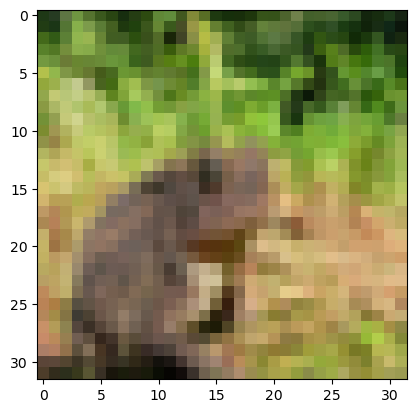

In [78]:
import matplotlib.pyplot as plt

plt.imshow(real_data[0,...].permute(1, 2, 0).cpu())

In [81]:
fid = fid_score(real_data, fake_data)
fid

7.923732280731201